In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import json

In [3]:
df_cnd = pd.read_csv("Complications_and_Deaths-Hospital.csv")
df_cnd.head()
df = df_cnd[df_cnd['City/Town'].str.contains('NEW YORK', case=False, na=False)]

# Display the first few rows to verify
df.head()


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Measure ID,Measure Name,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Start Date,End Date
53751,330024,MOUNT SINAI HOSPITAL,ONE GUSTAVE L LEVY PLACE,NEW YORK,NY,10029,NEW YORK,(212) 241-7981,COMP_HIP_KNEE,Rate of complications for hip/knee replacement...,No Different Than the National Rate,394,3.3,2.2,5.1,NaN,07/01/2020,03/31/2023
53752,330024,MOUNT SINAI HOSPITAL,ONE GUSTAVE L LEVY PLACE,NEW YORK,NY,10029,NEW YORK,(212) 241-7981,MORT_30_AMI,Death rate for heart attack patients,No Different Than the National Rate,175,12,9.4,15.1,NaN,07/01/2020,06/30/2023
53753,330024,MOUNT SINAI HOSPITAL,ONE GUSTAVE L LEVY PLACE,NEW YORK,NY,10029,NEW YORK,(212) 241-7981,MORT_30_CABG,Death rate for CABG surgery patients,No Different Than the National Rate,128,2,1.0,4.1,NaN,07/01/2020,06/30/2023
53754,330024,MOUNT SINAI HOSPITAL,ONE GUSTAVE L LEVY PLACE,NEW YORK,NY,10029,NEW YORK,(212) 241-7981,MORT_30_COPD,Death rate for COPD patients,No Different Than the National Rate,139,8.3,5.9,11.6,NaN,07/01/2020,06/30/2023
53755,330024,MOUNT SINAI HOSPITAL,ONE GUSTAVE L LEVY PLACE,NEW YORK,NY,10029,NEW YORK,(212) 241-7981,MORT_30_HF,Death rate for heart failure patients,Better Than the National Rate,761,8.4,7.0,10.3,NaN,07/01/2020,06/30/2023


In [4]:
df["Measure Name"].unique()

array(['Rate of complications for hip/knee replacement patients',
       'Death rate for heart attack patients',
       'Death rate for CABG surgery patients',
       'Death rate for COPD patients',
       'Death rate for heart failure patients',
       'Death rate for pneumonia patients',
       'Death rate for stroke patients', 'Pressure ulcer rate',
       'Death rate among surgical inpatients with serious treatable complications',
       'Iatrogenic pneumothorax rate',
       'In-hospital fall-associated fracture rate',
       'Postoperative hemorrhage or hematoma rate',
       'Postoperative acute kidney injury requiring dialysis rate',
       'Postoperative respiratory failure rate',
       'Perioperative pulmonary embolism or deep vein thrombosis rate',
       'Postoperative sepsis rate', 'Postoperative wound dehiscence rate',
       'Abdominopelvic accidental puncture or laceration rate',
       'CMS Medicare PSI 90: Patient safety and adverse events composite'],
      dtype=ob

In [5]:
df['Measure ID'].unique()

array(['COMP_HIP_KNEE', 'MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD',
       'MORT_30_HF', 'MORT_30_PN', 'MORT_30_STK', 'PSI_03', 'PSI_04',
       'PSI_06', 'PSI_08', 'PSI_09', 'PSI_10', 'PSI_11', 'PSI_12',
       'PSI_13', 'PSI_14', 'PSI_15', 'PSI_90'], dtype=object)

In [6]:
# Create a dictionary mapping Measure IDs to Measure Names
measure_df = df[['Measure ID', 'Measure Name']].drop_duplicates()
# Display the mapping


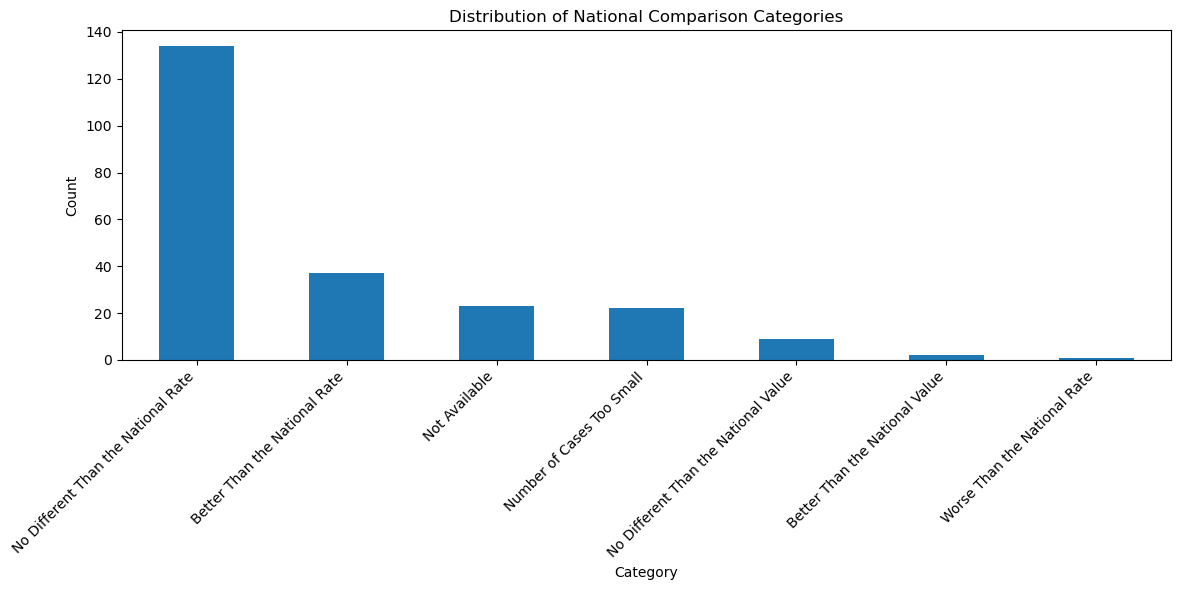

In [7]:
df['Compared to National'].unique()
plt.figure(figsize=(12, 6))
df['Compared to National'].value_counts().plot(kind='bar')
plt.title('Distribution of National Comparison Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
print(measure_df['Measure Name'].unique())

['Rate of complications for hip/knee replacement patients'
 'Death rate for heart attack patients'
 'Death rate for CABG surgery patients' 'Death rate for COPD patients'
 'Death rate for heart failure patients'
 'Death rate for pneumonia patients' 'Death rate for stroke patients'
 'Pressure ulcer rate'
 'Death rate among surgical inpatients with serious treatable complications'
 'Iatrogenic pneumothorax rate'
 'In-hospital fall-associated fracture rate'
 'Postoperative hemorrhage or hematoma rate'
 'Postoperative acute kidney injury requiring dialysis rate'
 'Postoperative respiratory failure rate'
 'Perioperative pulmonary embolism or deep vein thrombosis rate'
 'Postoperative sepsis rate' 'Postoperative wound dehiscence rate'
 'Abdominopelvic accidental puncture or laceration rate'
 'CMS Medicare PSI 90: Patient safety and adverse events composite']


In [10]:
def create_facility_dict(df):
    facilities = {}
    
    for facility_id in df['Facility ID'].unique():
        facility_data = df[df['Facility ID'] == facility_id]
        
        # Get basic facility info from first row
        basic_info = facility_data.iloc[0]
        
        facilities[facility_id] = {
            'name': basic_info['Facility Name'],
            'address': basic_info['Address'],
            'id': {}
        }
        
        # Add rate statistics for each measure
        for _, row in facility_data.iterrows():
            # Split Measure ID to get type (e.g., 'PSI', 'MORT', 'COMP')
            measure_type_code = row['Measure ID'].split('_')[0]
            
            # Determine type of condition based on code
            if measure_type_code == 'PSI':
                measure_type = 'Rate of potentially preventable complications'
            elif measure_type_code == 'MORT':
                measure_type = 'Mortality rate'
            elif measure_type_code == 'COMP':
                measure_type = 'Complications preventable/pre-existing'
            
            facilities[facility_id]['id'][row['Measure ID']] = {
                'condition_type': measure_type,
                'name_type': row['Measure Name'],  # Using actual Measure Name instead of startswith
                'score': row['Score'],
                'lower_estimate': row['Lower Estimate'],
                'higher_estimate': row['Higher Estimate']
            }
    
    return facilities

# Create the dictionary
ny_facilities = create_facility_dict(df)

# Save to JSON file with nice formatting
with open('ny_facilities.json', 'w') as f:
    json.dump(ny_facilities, f, indent=4)

# Print example to verify (optional)
first_facility_id = list(ny_facilities.keys())[0]
print(f"Sample facility data has been saved to ny_facilities.json")


NameError: name 'json' is not defined